<center><h1>YOLO11 Training with Privileged Information</h1>
<h2>Matthias Bartolo</h2>

</center>

<h3>Package Imports</h3>

In [1]:
# !pip install --upgrade roboflow ultralytics

In [2]:
# !pip install rasterio

**<h3>Required libraries.</h3>**
https://github.com/ultralytics/ultralytics/issues/2154

In [1]:
import torch
import os
# import ultralytics
import locale
import glob
import pandas as pd
import matplotlib.pyplot as plt

from IPython import display
from ultralytics import YOLO
from IPython.display import display, Image
from roboflow import Roboflow

%matplotlib inline

**<h3>Using GPU if one is available.</h3>**

In [2]:
!nvidia-smi

Wed Jan 29 08:15:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   30C    P8              8W /  200W |    1183MiB /  12282MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# Retrieving the current working directory
HOME = os.getcwd()
print(HOME)

e:\Testing\RGB Test


**<h3>Downloading the Roboflow dataset.</h3>**

In [5]:
if not os.path.isdir(os.path.join(HOME, 'datasets')):
    os.mkdir(os.path.join(HOME, 'datasets'))
os.chdir(os.path.join(HOME, 'datasets'))


# Zoo Animals Dataset
rf = Roboflow(api_key="nyynHs3oneLLx01D04rC")
project = rf.workspace("soda-dataset").project("01m-all")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


KeyboardInterrupt: 

In [22]:
# Added Code for Custom 4 Channel YOLO Model:
import torch.nn as nn
import torch

# Specify the model path and number of input channels
model_path = 'yolo11.pt'  # Path to your YOLO model file
num_channels = 4  # Example for multi-channel input (e.g., RGB + edge detection)

# UltraLytics YOLO Model implementation through pytorch

# class CustomYOLO(nn.Module):
#     def __init__(self, model_path, num_channels):
#         """
#         Initialize the custom YOLO model by adding a custom beginning layer for multi-channel input.

#         Args:
#             model_path (str): Path to the pre-trained YOLO model checkpoint.
#             num_channels (int): Number of input channels (e.g., 3 for RGB, 4 for RGB + edge).
#         """
#         super(CustomYOLO, self).__init__()
        
#         # Load the checkpoint
#         checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
        
#         # Extract the model from the checkpoint if it's a dictionary
#         if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
#             model = YOLO()  # Assuming YOLOModel is your architecture
#             model.load_state_dict(checkpoint["model_state_dict"])
#             self.model = model
#         else:
#             # Assume the checkpoint itself is the model
#             self.model = checkpoint
            
#         print(self.model)
        
#         # Modify the first convolution to handle multi-channel input
#         original_conv = self.model.model.model[0].conv
#         self.model.model.model[0].conv = nn.Conv2d(
#             num_channels, 
#             original_conv.out_channels, 
#             kernel_size=original_conv.kernel_size, 
#             stride=original_conv.stride, 
#             padding=original_conv.padding, 
#             bias=original_conv.bias is not None
#         )

#     def forward(self, x):
#         return self.model(x)

# from ultralytics.nn.modules.conv import Conv  # Import the Conv layer from YOLO's common module

class CustomYOLO(YOLO):
    def __init__(self, model_path, num_channels):
        """
        Initialize the custom YOLO model by adding a custom beginning layer for multi-channel input.
        
        Args:
            model_path (str): Path to the pre-trained YOLO model.
            num_channels (int): Number of input channels (e.g., 3 for RGB, 4 for RGB + edge).
        """
        # Load the original YOLO model from the given path
        super(CustomYOLO, self).__init__(model_path)
        
        # Modify the first convolution to handle multi-channel input (num_channels)
        self.model.model[0].conv = nn.Conv2d(num_channels, 16, kernel_size=3, stride=2, padding=1, bias=False)
    

# Create the custom YOLO model
model = CustomYOLO(model_path, num_channels)

print(model)


CustomYOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_ru

In [23]:
# Assuming you have a 3-channel input tensor
sample_input = torch.randn(1, 3, 640, 640)  # RGB (3 channels)
sample_input = torch.cat([sample_input, torch.zeros(1, 1, 640, 640)], dim=1)  # Add an extra channel
sample_input/=255

print(sample_input.shape)
output = model(sample_input, save=True)
print(output)

torch.Size([1, 4, 640, 640])



RuntimeError: Given groups=1, weight of size [16, 4, 3, 3], expected input[1, 3, 640, 640] to have 4 channels, but got 3 channels instead

**<h3>Training the YOLO11 model.</h3>**

In [8]:
# Specifying the paths
yaml_path  = dataset.location+"/data.yaml"

# Specifying the model path
model_path = 'yolo11n.pt'

# Creating YOLO object
model = YOLO(model_path)

# Specifying training parameters
num_epochs = 100  # Number of epochs
batch_size = 16 #8 # Adjust based on GPU memory
image_size = 640  # Decrease for faster training

# Training configuration
train_config = {
    'data': yaml_path,
    'imgsz': image_size,
    'batch': batch_size,
    'epochs': num_epochs,
    'device': 0,  # Use GPU 0
    # 'workers': 1,  # Number of data loading workers
    'optimizer': 'Adam',  # Use Adam optimizer
    'cache': True,  # Cache images for faster training
    'patience': 15,  # epochs to wait before decreasing LR
    'val': True,  # Run validation during training
    'plots': True,  # Run plots during training
}

# Train the model
model.train(**train_config)


New https://pypi.org/project/ultralytics/8.3.68 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.67  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=e:\Testing\RGB Test\datasets\01m-All-1/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=

train: Scanning E:\Testing\RGB Test\datasets\01m-All-1\train\labels.cache... 316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:00<?, ?it/s]


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.3GB RAM): 100%|██████████| 316/316 [00:01<00:00, 194.26it/s]
val: Scanning E:\Testing\RGB Test\datasets\01m-All-1\valid\labels.cache... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<?, ?it/s]


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 46/46 [00:00<00:00, 187.96it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.44G      1.732      3.473       1.47         35        640: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         46         84   0.000389     0.0256   0.000337   6.99e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.48G      1.667      2.447      1.491         47        640: 100%|██████████| 20/20 [00:01<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

                   all         46         84    0.00042     0.0464    0.00027   6.67e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.37G      1.682      2.201      1.505         44        640: 100%|██████████| 20/20 [00:01<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         46         84   8.12e-05     0.0382   4.68e-05   1.29e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.39G      1.684      2.079      1.497         43        640: 100%|██████████| 20/20 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         46         84   8.12e-05     0.0382   4.68e-05   1.29e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.37G       1.65      2.005      1.439         26        640: 100%|██████████| 20/20 [00:01<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

                   all         46         84      0.167     0.0289   5.22e-05    1.2e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.37G      1.561      1.892      1.393         27        640: 100%|██████████| 20/20 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         46         84   3.73e-05    0.00952   1.77e-05   4.38e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.37G      1.512      1.744      1.361         26        640: 100%|██████████| 20/20 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]

                   all         46         84    0.00018     0.0519   0.000125   3.86e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.37G      1.483       1.71      1.354         21        640: 100%|██████████| 20/20 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.77it/s]

                   all         46         84      0.176      0.112     0.0117    0.00351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.37G      1.417       1.57      1.322         37        640: 100%|██████████| 20/20 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.99it/s]

                   all         46         84      0.586      0.121      0.101     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.37G      1.425      1.619      1.316         26        640: 100%|██████████| 20/20 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.44it/s]

                   all         46         84      0.794      0.114      0.124     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.37G      1.323      1.523      1.271         36        640: 100%|██████████| 20/20 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.11it/s]

                   all         46         84       0.58     0.0905     0.0965     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.37G      1.361      1.448      1.273         39        640: 100%|██████████| 20/20 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         46         84       0.56     0.0446     0.0229     0.0114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.37G      1.295      1.414      1.228         29        640: 100%|██████████| 20/20 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]

                   all         46         84       0.38      0.127     0.0544     0.0317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.37G      1.296      1.393      1.244         35        640: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.71it/s]

                   all         46         84      0.625       0.11      0.141     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.37G      1.287       1.37      1.242         38        640: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.70it/s]

                   all         46         84      0.862      0.159      0.193      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.39G       1.29      1.377      1.201         39        640: 100%|██████████| 20/20 [00:01<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.83it/s]

                   all         46         84      0.698      0.165      0.211      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.37G      1.246       1.32       1.19         40        640: 100%|██████████| 20/20 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         46         84       0.52      0.222       0.22      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.37G      1.268      1.283      1.225         40        640: 100%|██████████| 20/20 [00:01<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.30it/s]

                   all         46         84      0.253      0.427      0.269      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.37G      1.286       1.34       1.22         37        640: 100%|██████████| 20/20 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.59it/s]

                   all         46         84      0.224      0.393      0.221      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.39G      1.295      1.336      1.213         36        640: 100%|██████████| 20/20 [00:01<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.26it/s]

                   all         46         84      0.231      0.305       0.24      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.37G       1.22      1.248      1.179         36        640: 100%|██████████| 20/20 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]

                   all         46         84      0.428      0.273      0.317      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.37G       1.24      1.265      1.189         45        640: 100%|██████████| 20/20 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]

                   all         46         84       0.61      0.237      0.359      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.37G      1.213      1.221      1.184         46        640: 100%|██████████| 20/20 [00:01<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]

                   all         46         84      0.338      0.373      0.235      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.37G      1.209      1.185      1.177         29        640: 100%|██████████| 20/20 [00:01<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

                   all         46         84      0.236      0.391      0.322       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.37G      1.189      1.212      1.173         40        640: 100%|██████████| 20/20 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.02it/s]

                   all         46         84      0.202      0.453      0.298      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.37G      1.166      1.191      1.161         37        640: 100%|██████████| 20/20 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         46         84      0.392      0.287      0.296       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.37G      1.097      1.115      1.108         34        640: 100%|██████████| 20/20 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]

                   all         46         84      0.382      0.339      0.275      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.37G      1.116       1.13      1.129         44        640: 100%|██████████| 20/20 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.74it/s]

                   all         46         84      0.241      0.419      0.297        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.37G      1.145      1.113      1.142         52        640: 100%|██████████| 20/20 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.55it/s]

                   all         46         84      0.548      0.381      0.376      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.37G      1.163      1.128      1.154         44        640: 100%|██████████| 20/20 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         46         84      0.295      0.485      0.356      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.37G      1.112      1.081      1.112         41        640: 100%|██████████| 20/20 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]

                   all         46         84      0.358      0.308      0.296      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.37G      1.101      1.038       1.11         39        640: 100%|██████████| 20/20 [00:01<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.63it/s]

                   all         46         84      0.289      0.534       0.38      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.37G      1.115      1.031      1.125         56        640: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]

                   all         46         84      0.445      0.381      0.451      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.37G       1.05       1.02      1.099         44        640: 100%|██████████| 20/20 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.91it/s]

                   all         46         84      0.432      0.407      0.348       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.39G       1.07     0.9942      1.105         37        640: 100%|██████████| 20/20 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.41it/s]

                   all         46         84      0.221      0.445      0.291      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.37G       1.03      1.021      1.084         33        640: 100%|██████████| 20/20 [00:01<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]

                   all         46         84      0.344       0.41      0.358      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.37G      1.032     0.9613      1.066         38        640: 100%|██████████| 20/20 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.45it/s]

                   all         46         84      0.288       0.45      0.317      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.37G      1.059     0.9555      1.081         38        640: 100%|██████████| 20/20 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.82it/s]

                   all         46         84      0.261      0.386      0.296       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.37G      1.029     0.9174      1.068         50        640: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.40it/s]

                   all         46         84      0.337      0.417      0.359      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.37G      1.044     0.9226      1.074         32        640: 100%|██████████| 20/20 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.65it/s]

                   all         46         84      0.609      0.391       0.47      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.37G      1.028     0.9288      1.083         28        640: 100%|██████████| 20/20 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]

                   all         46         84      0.408      0.521      0.413      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.37G      1.045     0.9455      1.083         31        640: 100%|██████████| 20/20 [00:01<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.30it/s]

                   all         46         84      0.475      0.343      0.369      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.37G       1.08     0.9685      1.108         28        640: 100%|██████████| 20/20 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.86it/s]

                   all         46         84       0.46      0.404      0.417      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.37G      1.041     0.8778      1.081         41        640: 100%|██████████| 20/20 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.00it/s]

                   all         46         84       0.48      0.418       0.47      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.37G      1.034     0.9125      1.075         40        640: 100%|██████████| 20/20 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.93it/s]

                   all         46         84      0.377      0.648      0.439      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.37G      1.026     0.8968      1.075         39        640: 100%|██████████| 20/20 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]

                   all         46         84       0.62      0.322       0.41       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.37G     0.9958     0.9064      1.065         34        640: 100%|██████████| 20/20 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.51it/s]

                   all         46         84      0.482       0.45      0.474      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.37G     0.9733     0.8459      1.044         38        640: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.24it/s]

                   all         46         84      0.527      0.476      0.482       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.39G      1.006      0.866      1.058         34        640: 100%|██████████| 20/20 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.79it/s]

                   all         46         84      0.517      0.447       0.51      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.37G      1.005     0.8826      1.057         40        640: 100%|██████████| 20/20 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.82it/s]

                   all         46         84      0.656      0.555      0.575      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.37G     0.9951       0.82      1.068         33        640: 100%|██████████| 20/20 [00:01<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.89it/s]

                   all         46         84      0.581      0.468      0.554      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.37G     0.9888     0.8193      1.053         41        640: 100%|██████████| 20/20 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]

                   all         46         84      0.438      0.534      0.515      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.37G     0.9341     0.8098      1.035         48        640: 100%|██████████| 20/20 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.94it/s]

                   all         46         84       0.51      0.485      0.488      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.37G     0.9589     0.8053      1.041         36        640: 100%|██████████| 20/20 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]

                   all         46         84      0.543      0.605      0.545      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.39G     0.9841     0.7847      1.047         37        640: 100%|██████████| 20/20 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]

                   all         46         84      0.548      0.541      0.542      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.37G     0.9587     0.8092      1.038         48        640: 100%|██████████| 20/20 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.11it/s]

                   all         46         84      0.524      0.527      0.508      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.37G     0.9308     0.7621      1.023         37        640: 100%|██████████| 20/20 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]

                   all         46         84      0.809       0.43      0.551      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.39G     0.9457     0.7635      1.035         24        640: 100%|██████████| 20/20 [00:01<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.78it/s]

                   all         46         84      0.525      0.396      0.527      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.39G     0.9559     0.7814      1.051         44        640: 100%|██████████| 20/20 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.80it/s]

                   all         46         84      0.587      0.488      0.495      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.37G     0.9314     0.7921      1.032         28        640: 100%|██████████| 20/20 [00:01<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.59it/s]

                   all         46         84      0.547      0.467      0.514      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.37G     0.9308     0.7717      1.026         41        640: 100%|██████████| 20/20 [00:01<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.97it/s]

                   all         46         84      0.529      0.476      0.518      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.39G     0.9135     0.7392      1.024         32        640: 100%|██████████| 20/20 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.20it/s]

                   all         46         84      0.505      0.432      0.431      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.37G      0.876     0.7107     0.9986         50        640: 100%|██████████| 20/20 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.06it/s]

                   all         46         84      0.533      0.485      0.473      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.37G      0.905     0.7258      1.014         21        640: 100%|██████████| 20/20 [00:01<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.62it/s]

                   all         46         84      0.332      0.561       0.45       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.37G     0.9034     0.7557      1.021         45        640: 100%|██████████| 20/20 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.04it/s]

                   all         46         84      0.608       0.55      0.605      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.39G     0.9056     0.7446      1.004         35        640: 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.69it/s]

                   all         46         84      0.614      0.494       0.56      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.37G     0.8797     0.7131     0.9929         53        640: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.19it/s]

                   all         46         84      0.595      0.569      0.571       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.39G     0.8823     0.7176     0.9965         32        640: 100%|██████████| 20/20 [00:01<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.46it/s]

                   all         46         84      0.578      0.662      0.632      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.39G     0.8899     0.6808      0.994         32        640: 100%|██████████| 20/20 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.48it/s]

                   all         46         84      0.583      0.525      0.548      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.39G     0.8731     0.6941      1.001         45        640: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]

                   all         46         84      0.521      0.637       0.56      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.37G     0.8884     0.6975      1.019         30        640: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]

                   all         46         84      0.597      0.513      0.552      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.37G     0.8999     0.7412       1.01         41        640: 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.49it/s]

                   all         46         84      0.611      0.538      0.581      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.37G     0.8825     0.6925          1         42        640: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.01it/s]

                   all         46         84      0.514      0.461      0.503      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.39G     0.8931     0.6788      1.014         40        640: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.10it/s]

                   all         46         84      0.485      0.538       0.56      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.39G     0.8794      0.686      1.001         28        640: 100%|██████████| 20/20 [00:01<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.69it/s]

                   all         46         84      0.531       0.51      0.571      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.37G     0.8315     0.6346     0.9905         32        640: 100%|██████████| 20/20 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]

                   all         46         84       0.61      0.592      0.601      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.37G     0.8366     0.6573     0.9831         38        640: 100%|██████████| 20/20 [00:01<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.96it/s]

                   all         46         84      0.631      0.563      0.582      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.39G     0.8198     0.6287     0.9728         48        640: 100%|██████████| 20/20 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.25it/s]

                   all         46         84      0.601      0.587      0.578      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.37G      0.798     0.6152     0.9581         41        640: 100%|██████████| 20/20 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.66it/s]

                   all         46         84      0.514      0.484      0.513       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.37G     0.8032      0.643     0.9686         32        640: 100%|██████████| 20/20 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.97it/s]

                   all         46         84      0.615       0.44      0.512      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.37G      0.775     0.6191     0.9527         38        640: 100%|██████████| 20/20 [00:01<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.22it/s]

                   all         46         84      0.608      0.572      0.589      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.39G     0.8027     0.6362     0.9592         39        640: 100%|██████████| 20/20 [00:01<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.08it/s]

                   all         46         84      0.592      0.522      0.567       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.37G     0.8283     0.6365      0.983         31        640: 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.92it/s]

                   all         46         84      0.625      0.487      0.555      0.383
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 68, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



83 epochs completed in 0.047 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.67  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]


                   all         46         84      0.579      0.662      0.632      0.464
  clear_plastic_bottle         12         16      0.796      0.731       0.78      0.531
             drink_can         25         35      0.829      0.968      0.973      0.735
          drink_carton          5          6       0.54      0.833      0.664      0.543
          glass_bottle         11         13      0.545      0.615      0.591      0.443
             glass_jar          5          5      0.451        0.6      0.609      0.404
  other_plastic_bottle          5          9      0.313      0.222      0.174      0.131
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002149895BC10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

**<h3>Validating the YOLO11 model on the Validation subset.</h3>**

In [9]:
locale.getpreferredencoding = lambda: "UTF-8"
# !pip install aspose-words

In [10]:
model.val() #This will output a train file however it will be on the validation data

Ultralytics 8.3.67  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning E:\Testing\RGB Test\datasets\01m-All-1\valid\labels.cache... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<?, ?it/s]


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 46/46 [00:00<00:00, 191.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


                   all         46         84      0.564      0.641      0.628      0.463
  clear_plastic_bottle         12         16      0.792      0.716       0.78      0.541
             drink_can         25         35      0.829      0.968       0.97      0.735
          drink_carton          5          6      0.529      0.833      0.658      0.534
          glass_bottle         11         13      0.567      0.615      0.599       0.46
             glass_jar          5          5      0.453        0.6      0.609      0.404
  other_plastic_bottle          5          9      0.214      0.111      0.149      0.107
Speed: 1.1ms preprocess, 6.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002149830C220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

**<h3>Validating the YOLO11 model on the Testing subset.</h3>**

In [11]:
model.val(split='test') #This will output a train file however it will be on the test data

Ultralytics 8.3.67  Python-3.9.19 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)


val: Scanning E:\Testing\RGB Test\datasets\01m-All-1\test\labels.cache... 90 images, 0 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 90/90 [00:00<00:00, 210.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


                   all         90        141      0.789      0.683      0.803      0.614
  clear_plastic_bottle         29         33      0.828       0.73      0.888       0.68
             drink_can         38         53      0.873      0.906      0.933      0.723
          drink_carton          8          8      0.607       0.75       0.73       0.63
          glass_bottle         16         18       0.86      0.682      0.821       0.59
             glass_jar         11         11       0.78      0.364      0.628        0.4
  other_plastic_bottle         15         18      0.786      0.667      0.816      0.659
Speed: 0.6ms preprocess, 5.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021497F0DD90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

**<h3>Training Results.</h3>**

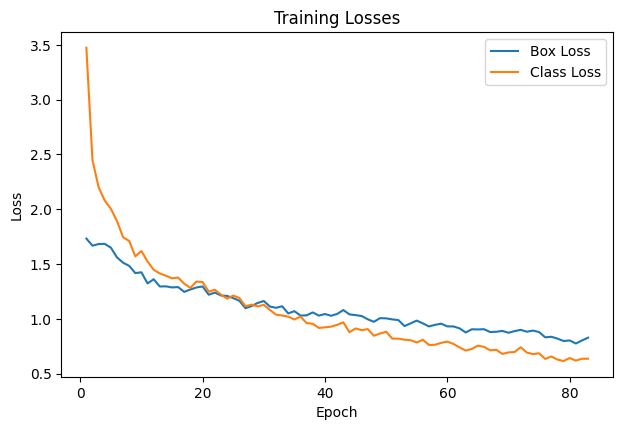

In [12]:
# # Replace 'path/to/your/data.csv' with the actual path to your CSV file
file_path = 'E:/Testing/RGB Test/datasets/runs/detect/train/results.csv'

column_name = 'epoch'

# Read the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Remove leading spaces from column names
data.columns = data.columns.str.strip()

# Plotting
plt.figure(figsize=(12, 8))

# Plotting the training losses
plt.subplot(2, 2, 1)
plt.plot(data['epoch'], data['train/box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['train/cls_loss'], label='Class Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


**<h3>Validation Results.</h3>**

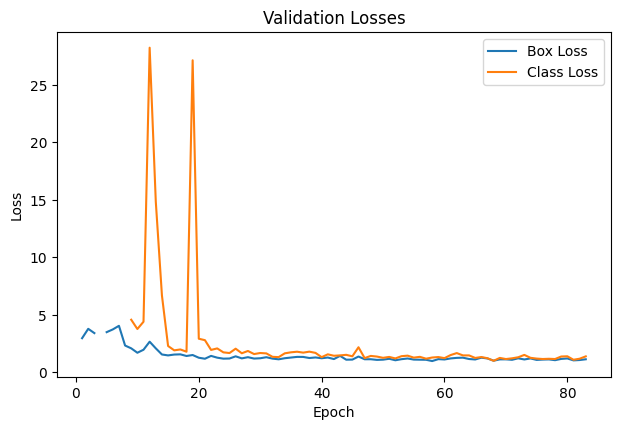

In [13]:
# Plotting
plt.figure(figsize=(12, 8))

# Plotting the training losses
plt.subplot(2, 2, 1)
plt.plot(data['epoch'], data['val/box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['val/cls_loss'], label='Class Loss')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()